# Explore confidence scores


In [4]:
from utils import *

from datasets import load_from_disk
from IPython.display import HTML as html_print
import matplotlib.pyplot as plt

In [7]:
fleurs_en_wav2vec = load_from_disk(os.path.join(predictions_path, 'fleurs_en_wav2vec'))
fleurs_en_whisper = load_from_disk(os.path.join(predictions_path, 'fleurs_en_whisper'))

In [11]:
def html_display_confidence(rows_ids):
    """
    Compute html string with confidence color per token, ground truth and wer
    """

    final_text = ""

    def cstr(s, color='black'):
        return "<text style=color:{}>{}</text>".format(color, s)

    def map_float_rgb(f, m, M):
        rgb = 'rgb({},{},0)'.format(int(255 * (1 - ((f - m) / (M - m)))), int(200 * (f - m) / (M - m)))
        return rgb

    for row_index in rows_ids:
        tokens_wav2vec = fleurs_en_wav2vec[row_index]['tokens_pred']
        probs_tokens_wav2vec = fleurs_en_wav2vec[row_index]['probs_tokens_pred']
        tokens_whisper = fleurs_en_whisper[row_index]['tokens_pred']
        probs_tokens_whisper = fleurs_en_whisper[row_index]['probs_tokens_pred']
        idx_elims = []
        len_tokens_whisper = len(tokens_whisper)
        for idx, token in enumerate(tokens_whisper):
            if idx > 0: tokens_whisper[idx] = tokens_whisper[idx].replace('Ġ', ' ')
            else: tokens_whisper[idx] = tokens_whisper[idx].replace('Ġ', '')
            if token == '.' or token == ',': idx_elims.append(idx)
        tokens_whisper = [tokens_whisper[i] for i in range(len_tokens_whisper) if i not in idx_elims]
        probs_tokens_whisper = [probs_tokens_whisper[i] for i in range(len_tokens_whisper) if i not in idx_elims]
        


        min_prob_whisper = min(probs_tokens_whisper)
        max_prob_whisper = max(probs_tokens_whisper)
        min_prob_wav2vec = min(probs_tokens_wav2vec)
        max_prob_wav2vec = max(probs_tokens_wav2vec)

        final_text += "<b>w2v2+4g : " + " ".join([cstr(s=tokens_wav2vec[idx].lower(), color=map_float_rgb(probs_tokens_wav2vec[idx], min_prob_wav2vec, max_prob_wav2vec)) for idx in range(len(tokens_wav2vec))]) + "<br>"
        final_text += "whisper " + 1 * "&nbsp " + ":  " + "".join([cstr(s=tokens_whisper[idx].lower(), color=map_float_rgb(probs_tokens_whisper[idx], min_prob_whisper, max_prob_whisper)) for idx in range(len(tokens_whisper))]) + "<br>"
        final_text += "g.truth " + 2 * "&nbsp " + ":  " + fleurs_en_whisper[row_index]['transcription'] + "<br>"
        final_text += "WER w2v " + 0 * " &nbsp" + ": " + str(round(100 * fleurs_en_wav2vec[row_index]['wer'], 1)) + "% &nbsp - confidence range : [" + cstr(str(round(100 * min_prob_wav2vec, 1)) + '%', 'rgb(255,0,0)') + ", " + cstr(str(round(100 * max_prob_wav2vec, 1)) + '%', 'rgb(0,200,0)') + "]<br>"
        final_text += "WER wsp " + 0 * " &nbsp" + ": " + str(round(100 * fleurs_en_whisper[row_index]['wer'], 1)) + "% &nbsp - confidence range : [" + cstr(str(round(100 * min_prob_whisper, 1)) + '%', 'rgb(255,0,0)') + ", " + cstr(str(round(100 * max_prob_whisper, 1)) + '%', 'rgb(0,200,0)') + "]<br><br><br>"

    return final_text

In [12]:
html_print(html_display_confidence([98,107,119]))

In [14]:
import pandas as pd
import seaborn as sns
from scipy import stats

In [15]:
# instantiate dict of heuristics
heuristics_wav2vec = dict({'wer':[], 'avg_prob_tokens':[]})

# fill dict
for row in fleurs_en_wav2vec:
    heuristics_wav2vec['wer'].append(row['wer'])
    heuristics_wav2vec['avg_prob_tokens'].append(np.mean(row['probs_tokens_pred']))

# export to pd dataframe
heuristics_wav2vec = pd.DataFrame.from_dict(heuristics_wav2vec)

# remove outliers
heuristics_wav2vec = heuristics_wav2vec[(np.abs(stats.zscore(heuristics_wav2vec)) < 3).all(axis=1)]

In [16]:
# instantiate dict of heuristics
heuristics_whisper = dict({'wer':[], 'avg_prob_tokens':[]})

# fill dict
for row in fleurs_en_whisper:
    heuristics_whisper['wer'].append(row['wer'])
    heuristics_whisper['avg_prob_tokens'].append(np.mean(row['probs_tokens_pred']))

# export to pd dataframe
heuristics_whisper = pd.DataFrame.from_dict(heuristics_whisper)

# remove outliers
heuristics_whisper = heuristics_whisper[(np.abs(stats.zscore(heuristics_whisper)) < 3).all(axis=1)]

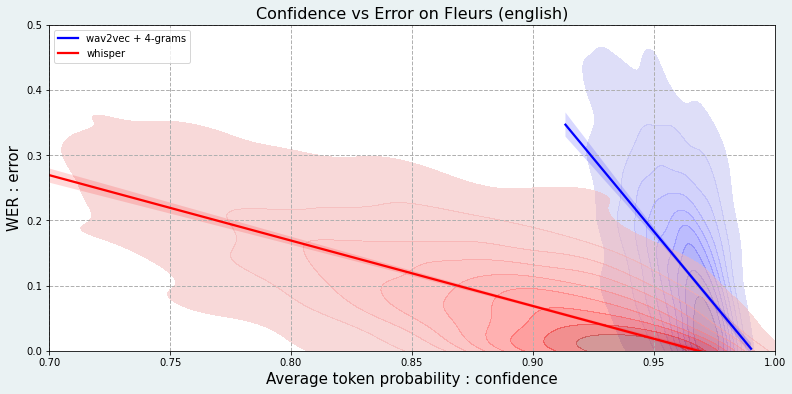

In [17]:
f, ax = plt.subplots(figsize=(13,6),facecolor=np.array([234/255,242/255,243/255]))
ax.grid(True, linewidth=1, linestyle='dashed')
#sns.set_theme(style="ticks")
ax = sns.kdeplot(data=heuristics_wav2vec, x="avg_prob_tokens", y="wer", 
        fill = True, color='blue', alpha=0.5, ax=ax)
ax = sns.kdeplot(data=heuristics_whisper, x="avg_prob_tokens", y="wer", 
        fill = True, color='red', alpha = 0.5, ax=ax)
ax = sns.regplot(data=heuristics_wav2vec, x="avg_prob_tokens", y="wer", color="blue", scatter=None, ci=95, label='wav2vec + 4-grams')
ax = sns.regplot(data=heuristics_whisper, x="avg_prob_tokens", y="wer", color="red", scatter=None, ci=95, label='whisper')
ax.set_xlabel("Average token probability : confidence", fontsize=15)
ax.set_ylabel("WER : error", fontsize=15)
ax.set_xlim(0.7,1)
ax.set_ylim(0,0.5)
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(loc = "upper left")
plt.title("Confidence vs Error on Fleurs (english)", fontsize=16)
plt.show()